<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Neural-Network-Classes" data-toc-modified-id="Neural-Network-Classes-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Neural Network Classes</a></span></li><li><span><a href="#Additional-Required-Functions" data-toc-modified-id="Additional-Required-Functions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Additional Required Functions</a></span></li><li><span><a href="#Application-to-Three-Data-Sets" data-toc-modified-id="Application-to-Three-Data-Sets-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Application to Three Data Sets</a></span></li><li><span><a href="#Grading" data-toc-modified-id="Grading-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Grading</a></span></li><li><span><a href="#Extra-Credit" data-toc-modified-id="Extra-Credit-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Extra Credit</a></span></li></ul></div>

<font size=10>Neural Networks in Pytorch</font>

In this assignment, you will
1. complete the implementations of neural network classes,
2. define the new function `multiple_runs_classification`,
3. define the new function `multiple_runs_convolutional`,
4. copy and paste `percent_correct` and `confusion_matrx` from previous notes,
4. present and discuss regression results on automobile MPG data,
5. present and discuss classification results on diabetes data,
6. present and discuss classification results on small version of MNIST data.

# Neural Network Classes

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from math import floor
import pandas as pd
import os


For this assignment, start with implementations of the following classes:
* `NeuralNetworkTorch`: copied and pasted from Lecture Notes 16.1
* `NeuralNetworkClassifierTorch`: copied and pasted from Lecture Notes 16.1
* `NeuralNetworkClassifierConvolutionalTorch`: copied and pasted from Lecture Notes 16.1 and completed.

The `train` functions in this classes have two additional arguments, `Xval`nad `Tval`:

```python
   def train(self, Xtrain, Ttrain, n_epochs, learning_rate=0.01, method='adam', verbose=True, 
             Xval=None, Tval=None):
```

where `Xtrain` and `Ttrain` are the usual two arguments used to train the network, and `Xval` and `Tval` are the validation data matrices.  `Xval` and `Tval` are only used to calculate the performance (MSE or NLL) once per epoch.  If the performance is better than the best so far, update an array that is storing the best weight values so far, and also update the best performance so far.  When training is complete, copy the stored best-so-far weights back into the network.  If `Xval` is `None`, then this step is ignored and the weights in the neural network at the end of training are not modified.

In [2]:
######################################################################
## NeuralNetwork  for regression
######################################################################

class NeuralNetworkTorch(torch.nn.Module):

    def __init__(self, n_inputs, n_hiddens_list, n_outputs, device='cpu'):

        super().__init__()

        self.n_inputs = n_inputs
        self.n_hiddens_list = n_hiddens_list
        self.n_outputs = n_outputs
        self.device = device

        self.n_layers = len(n_hiddens_list) + 1
        
        self.layers = torch.nn.ModuleList()
        for n_units in n_hiddens_list:
            self.layers.append(self._make_tanh_layer(n_inputs, n_units))
            n_inputs = n_units
        self.layers.append(torch.nn.Linear(n_inputs, n_outputs))

        self.stand_params = None
        self.error_trace = []
        self.error_trace_val = []

    def _make_tanh_layer(self, n_inputs, n_units):
        return torch.nn.Sequential(torch.nn.Linear(n_inputs, n_units),
                                   torch.nn.Tanh())

    def __repr__(self):
        return f'NeuralNetworkTorch({self.n_inputs}, {self.n_hiddens_list}, {self.n_outputs}, device={self.device})'

    def forward(self, Xst):
        Ys = [Xst]
        for layer in self.layers:
            Ys.append(layer(Ys[-1]))
        return Ys[1:]  # remove X from Ys

    def train(self, Xtrain, Ttrain, n_epochs=10, learning_rate=0.01, method='adam', verbose=True, Xval=None, Tval=None):

        if isinstance(Xtrain, np.ndarray):
            Xtrain = torch.from_numpy(Xtrain.astype(np.float32))
        if isinstance(Ttrain, np.ndarray):
            Ttrain = torch.from_numpy(Ttrain.astype(np.float32))

        if Xval is not None:
            if isinstance(Xval, np.ndarray):
                Xval = torch.from_numpy(Xval.astype(np.float32))
            if isinstance(Tval, np.ndarray):
                Tval = torch.from_numpy(Tval.astype(np.float32))

        self.stand_params = self.calc_standardize_parameters(Xtrain, Ttrain)
        Xtrain = self.standardize_X(Xtrain)
        Ttrain = self.standardize_T(Ttrain)
        if Xval is not None:
            Xval = self.standardize_X(Xval)
            Tval = self.standardize_T(Tval)

        if method == 'sgd':
            optimizer = torch.optim.SGD(self.parameters(), lr=learning_rate)
        elif method == 'adam':
            optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        else:
            print('train: method must be \'sgd\', or \'adam\'.')

        error_f = torch.nn.MSELoss()

        self.best_epoch = None
        best_mse = None
        best_weights = self.get_all_weights()
        
        for epoch in range(n_epochs):

            Ytrain = self.forward(Xtrain)[-1]  # to get last layer output
            mse = error_f(Ytrain, Ttrain)

            optimizer.zero_grad()
            mse.backward()
            optimizer.step()

            self.error_trace.append(mse.sqrt())
            
            if Xval is not None:
                Yval = self.forward(Xval)[-1]
                mse_val = error_f(Yval, Tval)
                self.error_trace_val.append(mse_val.sqrt())
                
                if best_mse is None or mse_val < best_mse:
                    best_mse = mse_val
                    best_weights = self.get_all_weights()
                    self.best_epoch = epoch

            if verbose and ((epoch+1) % (n_epochs // 10) == 0 or epoch == n_epochs - 1):
                if Xval is not None:
                    print(f'Epoch {epoch+1} RMSE train {self.error_trace[-1]:.4f} val {self.error_trace_val[-1]:.4f}')
                else:
                    print(f'Epoch {epoch+1} RMSE {self.error_trace[-1]:.4f}')
                
        if Xval is not None:
            self.set_all_weights(best_weights)

        return self

    def use(self, X, return_hidden_layer_outputs=False):
        if isinstance(X, np.ndarray):
            X = torch.from_numpy(X.astype(np.float32))

        Xst = self.standardize_X(X)
        Ys = self.forward(Xst)
        Y = Ys[-1]
        Y = self.unstandardize_T(Y)
        Zs = Ys[:-1]
        Y = Y.detach().cpu().numpy()
        Zs = [Z.detach().cpu().numpy() for Z in Zs]
        return (Y, Zs) if return_hidden_layer_outputs else Y

    def get_error_trace(self):
        return self.error_trace

    def get_error_traces(self):
        return self.error_trace, self.error_trace_val, self.best_epoch

    def calc_standardize_parameters(self, X, T):
        Xmeans = X.mean(axis=0)
        Xstds = X.std(axis=0)
        Xstds[Xstds == 0] = Xstds[Xstds > 0].mean(axis=0)
        if T is None:
            return {'Xmeans': Xmeans, 'Xstds': Xstds}
        else:
            Tmeans = T.mean(axis=0)
            Tstds = T.std(axis=0)
            return {'Xmeans': Xmeans, 'Xstds': Xstds, 'Tmeans': Tmeans, 'Tstds': Tstds}

    def standardize_X(self, X):
        return (X - self.stand_params['Xmeans']) / self.stand_params['Xstds']

    def unstandardize_X(self, Xst):
        return Xst * self.stand_params['Xstds'] + self.stand_params['Xmeans']

    def standardize_T(self, T):
        return (T - self.stand_params['Tmeans']) / self.stand_params['Tstds']

    def unstandardize_T(self, Tst):
        return Tst * self.stand_params['Tstds'] + self.stand_params['Tmeans']

    def get_Ws(self):
        Ws = []
        for layer in self.layers:
            W_and_bias = list(layer.parameters())
            W = W_and_bias[0].detach().numpy()
            Wbias = W_and_bias[1].detach().numpy().T.reshape(1, -1)
            if W.ndim == 4:
                W = np.moveaxis(W, 0, 3)  # first dim is units. Move it to last, fourth, dim
                n_units = Wbias.shape[-1]
                W = W.reshape(-1, n_units)
            else:
                W = W.T
            Ws.append(np.vstack((Wbias, W)))
        return Ws
        
    def get_all_weights(self):
        return torch.nn.utils.parameters_to_vector(self.parameters())

    def set_all_weights(self, all_weights):
        torch.nn.utils.vector_to_parameters(all_weights, self.parameters())

In [43]:
######################################################################
## NeuralNetworkClassifierTorch
######################################################################

class NeuralNetworkClassifierTorch(NeuralNetworkTorch):

    def __init__(self, n_inputs, n_hiddens_list, n_outputs, device="cpu"):
        
        if isinstance(n_inputs, list) or isinstance(n_inputs, tuple):
            super().__init__(np.prod(n_inputs), n_hiddens_list, n_outputs, device)
        
        else:
            super().__init__(n_inputs, n_hiddens_list, n_outputs, device)
              

        last_layer = self.layers[-1]
        new_last_layer = torch.nn.Sequential(last_layer,
                                             torch.nn.LogSoftmax(dim=1))  # across columns
        self.layers = self.layers[:-1]
        self.layers.append(new_last_layer)
        # self.layers = self.layers[:-1] + new_last_layer

    def __repr__(self):
        return f'NeuralNetworkClassifierTorch({self.n_inputs}, {self.n_hiddens_list}, {self.n_outputs}, device={self.device})'

    def train(self, Xtrain, Ttrain, n_epochs=10, learning_rate=0.01, method='adam', verbose=True, Xval=None, Tval=None):
        
        if isinstance(Xtrain, np.ndarray):
#             print("ur here")
            Xtrain = torch.from_numpy(Xtrain.astype(np.float32)).to(self.device)
            
        if isinstance(Ttrain, np.ndarray):
            Ttrain = torch.from_numpy(Ttrain.astype(np.float32)).to(self.device)

        if Xval is not None:
            if isinstance(Xval, np.ndarray):
                Xval = torch.from_numpy(Xval.astype(np.float32)).to(self.device)
            if isinstance(Tval, np.ndarray):
                Tval = torch.from_numpy(Tval.astype(np.float32)).to(self.device)
    
        Ttrain = Ttrain.long().reshape(-1)  # pytorch expects 1D tensor as labels
        if Xval is not None:
            Tval = Tval.long().reshape(-1)
        
        self.stand_params = self.calc_standardize_parameters(Xtrain, None)
        Xtrain = self.standardize_X(Xtrain)
        if Xval is not None:
            Xval = self.standardize_X(Xval)

        self.classes, counts = Ttrain.unique(return_counts=True)
        self.classes = self.classes.cpu().numpy()
        # self.most_common_class = self.classes[np.argmax(counts)]  # not used

        if method == 'sgd':
            optimizer = torch.optim.SGD(self.parameters(), lr=learning_rate)
        elif method == 'adam':
            optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        else:
            print('train: method must be \'sgd\', or \'adam\'.')

        neg_log_likelihood = torch.nn.NLLLoss()

        self.best_epoch = None
        best_nll = None
        best_weights = self.get_all_weights()
        
        for epoch in range(n_epochs):

            Ytrain = self.forward(Xtrain)[-1]  # to get last layer output as log(softmax(Y))
            nll = neg_log_likelihood(Ytrain, Ttrain)

            optimizer.zero_grad()
            nll.backward()
            optimizer.step()

            self.error_trace.append((-nll).exp())
            
            if Xval is not None:
                Yval = self.forward(Xval)[-1]
                nll_val = neg_log_likelihood(Yval, Tval)
                self.error_trace_val.append((-nll_val).exp())
                
                if best_nll is None or nll_val < best_nll:
                    best_nll = nll_val
                    best_weights = self.get_all_weights()
                    # print(f'epoch {epoch} first w {best_weights[0]}, nll train {self.error_trace[-1]} val {self.error_trace_val[-1]}')
                    self.best_epoch = epoch

            if verbose and ((epoch+1) % (n_epochs // 10) == 0 or epoch == n_epochs - 1):
                if Xval is not None:
                    print(f'Epoch {epoch+1} LL train {self.error_trace[-1]:.4f} val {self.error_trace_val[-1]:.4f}')
                else:
                    print(f'Epoch {epoch+1} NLL {self.error_trace[-1]:.4f}')

        if Xval is not None:
            # print(f'done epoch {epoch} first w {self.get_all_weights()[0]}')
            self.set_all_weights(best_weights)
            # print(f'after done epoch {epoch} first w {self.get_all_weights()[0]}')

        return self

    def use(self, X, return_hidden_layer_outputs=False):
        if isinstance(X, np.ndarray):
            X = torch.from_numpy(X.astype(np.float32))
  
        Xst = self.standardize_X(X)
        Ys = self.forward(Xst)
        Y = Ys[-1]
        Zs = Ys[:-1]
        probs = Y.detach().exp().cpu().numpy()  # ex() because net output is log(softmax())
        Zs = [Z.detach().cpu().numpy() for Z in Zs]
        classes = self.classes[np.argmax(probs, axis=1)].reshape(-1, 1)
        return (classes, probs, Zs) if return_hidden_layer_outputs else (classes, probs)

In [25]:
######################################################################
## NeuralNetworkClassifierConvolutionalTorch
######################################################################

class NeuralNetworkClassifierConvolutionalTorch(NeuralNetworkClassifierTorch):
    


    def __init__(self, n_inputs, n_conv_list, n_fc_list, n_outputs, device="cpu"):
        '''n_inputs: n_channels X n_rows X n_cols
n_conv_list: list of tuples of (n_units, kernel_size, stride)'''

        # Call constructor, but will discard the layers made and make new ones
        super().__init__(n_inputs, n_fc_list, n_outputs, device)
        

        self.n_channels, self.n_input_rows, self.n_input_cols = n_inputs
        self.n_conv_list = n_conv_list
        self.n_fc_list = n_fc_list
        self.n_outputs = n_outputs
        self.device = device

        self.layers = torch.nn.ModuleList()
        n_in_channels = self.n_channels
        
        output_rows, output_cols, output_channels = (self.n_input_rows,self.n_input_cols ,self.n_channels)# COMPLETE THIS
        rows = 0 
        columns =0
        for conv in n_conv_list:
            n_units, kernel_size, stride = conv
            (kernel_rows, kernel_cols) = (kernel_size, kernel_size) if np.isscalar(kernel_size) else kernel_size
            (stride_rows, stride_cols) = (stride, stride) if np.isscalar(stride) else stride

            self.layers.append(self._make_conv_layer(n_in_channels, n_units, kernel_size, stride))
            n_in_channels = n_units
            pad =0
            rows = floor((output_rows+(2*pad) - (kernel_rows))/stride_rows)+1
            columns = floor((output_cols+(2*pad) - (kernel_cols))/stride_cols)+1
            output_rows, output_cols, output_channels =(rows,columns,n_in_channels) # COMPLETE THIS

#         print(output_rows, output_cols, output_channels)
        # Add Flatten to output of last convolutional layer
        self.layers[-1].add_module('flatten', torch.nn.Flatten())
        
        # Calculate the total number of inputs entering each unit in the first fully-connected layer
        n_inputs = output_rows*output_cols*output_channels  # COMPLETE THIS

        for n_units in n_fc_list:
            self.layers.append(self._make_tanh_layer(n_inputs, n_units))
            n_inputs = n_units
            
        self.layers.append(torch.nn.Sequential(torch.nn.Linear(n_inputs, n_outputs),
                                               torch.nn.LogSoftmax(dim=1)))  # across columns

    def _make_conv_layer(self, n_in_channels, n_units, kernel_size, stride):
        return torch.nn.Sequential(torch.nn.Conv2d(n_in_channels, n_units, kernel_size, stride),
                                   torch.nn.Tanh())

    def __repr__(self):
        return f'''NeuralNetworkClassifierConvolutionalTorch(n_inputs={self.n_inputs}, n_conv_list={self.n_conv_list}, n_fc_list={self.n_fc_list}, n_outputs={self.n_outputs}, device={self.device})'''

# Additional Required Functions

Include in this notebook the following functions we have defined before
* `percent_correct`
* `partition`
* `multiple_runs_regression`

and define two new functions
* `multiple_runs_classification`
* `multiple_runs_convolutional`

based on `multiple_runs_regression`.

In [5]:
def percent_correct(Y, T):
    if isinstance(T, np.ndarray):
        return np.mean(Y == T) * 100
    else:
        return np.mean(Y==T.cpu().numpy())*100
   

In [6]:
def partition(X, T, fractions, shuffle=True, classification=False):
    """Usage: Xtrain,Train,Xvalidate,Tvalidate,Xtest,Ttest = partition(X,T,(0.6,0.2,0.2),classification=True)
      X is nSamples x nFeatures.
      fractions can have just two values, for partitioning into train and test only
      If classification=True, T is target class as integer. Data partitioned
        according to class proportions.
        """
    train_fraction = fractions[0]
    if len(fractions) == 2:
        # Skip the validation step
        validate_fraction = 0
        test_fraction = fractions[1]
    else:
        validate_fraction = fractions[1]
        test_fraction = fractions[2]
        
    row_indices = np.arange(X.shape[0])
    if shuffle:
        np.random.shuffle(row_indices)
    
    if not classification:
        # regression, so do not partition according to targets.
        n = X.shape[0]
        n_train = round(train_fraction * n)
        n_validate = round(validate_fraction * n)
        n_test = round(test_fraction * n)
        if n_train + n_validate + n_test > n:
            n_test = n - n_train - n_validate
        Xtrain = X[row_indices[:n_train], :]
        Ttrain = T[row_indices[:n_train], :]
        if n_validate > 0:
            Xvalidate = X[row_indices[n_train:n_train + n_validate], :]
            Tvalidate = T[row_indices[n_train:n_train + n_validate], :]
        Xtest = X[row_indices[n_train + n_validate:n_train + n_validate + n_test], :]
        Ttest = T[row_indices[n_train + n_validate:n_train + n_validate + n_test], :]
        
    else:
        # classifying, so partition data according to target class
        classes = np.unique(T)
        train_indices = []
        validate_indices = []
        test_indices = []
        for c in classes:
            # row indices for class c
            rows_this_class = np.where(T[row_indices,:] == c)[0]
            # collect row indices for class c for each partition
            n = len(rows_this_class)
            n_train = round(train_fraction * n)
            n_validate = round(validate_fraction * n)
            n_test = round(test_fraction * n)
            if n_train + n_validate + n_test > n:
                n_test = n - n_train - n_validate
            train_indices += row_indices[rows_this_class[:n_train]].tolist()
            if n_validate > 0:
                validate_indices += row_indices[rows_this_class[n_train:n_train + n_validate]].tolist()
            test_indices += row_indices[rows_this_class[n_train + n_validate:n_train + n_validate + n_test]].tolist()
        Xtrain = X[train_indices, :]
        Ttrain = T[train_indices, :]
        if n_validate > 0:
            Xvalidate = X[validate_indices, :]
            Tvalidate = T[validate_indices, :]
        Xtest = X[test_indices, :]
        Ttest = T[test_indices, :]
    if n_validate > 0:
        return Xtrain, Ttrain, Xvalidate, Tvalidate, Xtest, Ttest
    else:
        return Xtrain, Ttrain, Xtest, Ttest

In [7]:
def rmse(Y, T):
    return np.sqrt(np.mean((T - Y) ** 2))

In [8]:
def multiple_runs_regression(n_partitions, X, T, fractions, n_hiddens_list, n_epochs, learning_rate):
    
    def rmse(Y, T):
        return np.sqrt(np.mean((T - Y) ** 2))

    print(f'Structure {n_hiddens_list}: Repetition', end=' ')
    results = []
    
    for rep in range(n_partitions):
        
        print(f'{rep + 1}', end=' ')
        
        Xtrain, Ttrain, Xval, Tval, Xtest, Ttest = partition(X, T, fractions,
                                                             shuffle=True, classification=False)
        
        nnet = NeuralNetworkTorch(X.shape[1], n_hiddens_list, T.shape[1])
        nnet.train(Xtrain, Ttrain, n_epochs, learning_rate, method='adam', Xval=Xval, Tval=Tval, verbose=False)

        
        Ytrain = nnet.use(Xtrain)
        Yval = nnet.use(Xval)
        Ytest = nnet.use(Xtest)
        
   
        
        structure = str(n_hiddens_list)
        results.extend([[structure, 'train', rmse(Ytrain, Ttrain)],
                        [structure, 'validation', rmse(Yval, Tval)],
                        [structure, 'test', rmse(Ytest, Ttest)]])
        
    print()
    return results

In [20]:
def multiple_runs_classification(n_partitions, X, T, fractions, n_hiddens_list, n_epochs, learning_rate):
 
    print(f'Structure {n_hiddens_list}: Repetition', end=' ')
    results = []
    for rep in range(n_partitions):
        
        print(f'{rep + 1}', end=' ')
        
        Xtrain, Ttrain, Xval, Tval, Xtest, Ttest = partition(X, T, fractions,
                                                             shuffle=True, classification=True)
        n_outputs = len(np.unique(Ttrain).astype(int))
        nnet = NeuralNetworkClassifierTorch(X.shape[1], n_hiddens_list, n_outputs)
        nnet.train(Xtrain, Ttrain, n_epochs, learning_rate, method='adam', Xval=Xval, Tval=Tval, verbose=False)
        train_percent=percent_correct(nnet.use(Xtrain)[0], Ttrain)
        val_percent = percent_correct(nnet.use(Xval)[0], Tval)
        test_percent = percent_correct(nnet.use(Xtest)[0], Ttest)

        structure = str(n_hiddens_list)
        results.extend([[structure, 'train', train_percent],
                        [structure, 'validation', val_percent],
                        [structure, 'test', test_percent]])
#         print(results)
    print()
    return results

In [10]:
def multiple_runs_convolutional(n_partitions, X, T, fractions, nconv, nfc, n_epochs, learning_rate):
 
    print(f'Structure {str(nconv)+ " " + str(nfc)}: Repetition', end=' ')
    results = []


    for rep in range(n_partitions):

        print(f'{rep + 1}', end=' ')

        Xtrain, Ttrain, Xval, Tval, Xtest, Ttest = partition(X, T, fractions,
                                                             shuffle=True, classification=True)

                
#         Xtest=torch.from_numpy(Xtest.astype(np.float32))
#         Ttest=torch.from_numpy(Ttest.astype(np.float32))
        n_outputs = len(np.unique(T).astype(int))

        nnet = NeuralNetworkClassifierConvolutionalTorch(X.shape[1:], nconv, nfc, n_outputs)

    

        nnet.train(Xtrain, Ttrain, n_epochs, learning_rate, method='adam', Xval=Xval, Tval=Tval, verbose=False)
        train_percent=percent_correct(nnet.use(Xtrain)[0], Ttrain)
        val_percent = percent_correct(nnet.use(Xval)[0], Tval)
        test_percent = percent_correct(nnet.use(Xtest)[0], Ttest)
#         print(nnet.use(Xtrain), Ttrain)
        structure = str(nconv)+ " " + str(nfc)
        results.extend([[structure, 'train', train_percent],
                        [structure, 'validation', val_percent],
                        [structure, 'test', test_percent]])

#         print(results)
    print()
    return results

Here is another function that you must use to analyze the performance for your two classification problems.

In [11]:
def confusion_matrix(Y_classes, T):
    class_names = np.unique(T)
    table = []
    for true_class in class_names:
        row = []
        for Y_class in class_names:
            row.append(100 * np.mean(Y_classes[T == true_class] == Y_class))
        table.append(row)
    conf_matrix = pd.DataFrame(table, index=class_names, columns=class_names)
    conf_matrix.style.background_gradient(cmap='Blues').format("{:.1f}")
    print(f'Percent Correct is {percent_correct(Y_classes, T)}')
    return conf_matrix

Here are examples of running `multiple_runs_classification` and `multiple_runs_convolutional`.

In [12]:
def makeImages(nEach):
    images = np.zeros((nEach * 2, 1, 20, 20))  # nSamples, nChannels, rows, columns
    radii = 3 + np.random.randint(10 - 5, size=(nEach * 2, 1))
    centers = np.zeros((nEach * 2, 2))
    for i in range(nEach * 2):
        r = radii[i, 0]
        centers[i, :] = r + 1 + np.random.randint(18 - 2 * r, size=(1, 2))
        x = int(centers[i, 0])
        y = int(centers[i, 1])
        if i < nEach:
            # squares
            images[i, 0, x - r:x + r, y + r] = 1.0
            images[i, 0, x - r:x + r, y - r] = 1.0
            images[i, 0, x - r, y - r:y + r] = 1.0
            images[i, 0, x + r, y - r:y + r + 1] = 1.0
        else:
            # diamonds
            images[i, 0, range(x - r, x), range(y, y + r)] = 1.0
            images[i, 0, range(x - r, x), range(y, y - r, -1)] = 1.0
            images[i, 0, range(x, x + r + 1), range(y + r, y - 1, -1)] = 1.0
            images[i, 0, range(x, x + r), range(y - r, y)] = 1.0
            # images += np.random.randn(*images.shape) * 0.5
        T = np.zeros((nEach * 2, 1))
        T[nEach:] = 1
    return images, T

nEach = 500
X, T = makeImages(nEach)
Xflat = X.reshape(X.shape[0], -1)
Xflat.shape, T.shape

((1000, 400), (1000, 1))

In [13]:
fractions = (0.6, 0.2, 0.2)
n_hiddens_list = [[], [2], [5], [10], [20, 20]]  # Notice the first one... []
n_epochs = 500
learning_rate = 0.01

n_partitions = 10

results = []
for nh in n_hiddens_list:
    results.extend(multiple_runs_classification(n_partitions, Xflat, T, fractions, nh, n_epochs, learning_rate))
    
resultsdf = pd.DataFrame(results, columns=('Structure', 'Partition', 'Percent_Correct'))

Structure []: Repetition 1 2 3 4 5 6 7 8 9 10 
Structure [2]: Repetition 1 2 3 4 5 6 7 8 9 10 
Structure [5]: Repetition 1 2 3 4 5 6 7 8 9 10 
Structure [10]: Repetition 1 2 3 4 5 6 7 8 9 10 
Structure [20, 20]: Repetition 1 2 3 4 5 6 7 8 9 10 


In [15]:
resultsdf

,Structure,Partition,Percent_Correct
0,[],train,98.500000
1,[],validation,94.500000
2,[],test,93.000000
3,[],train,94.833333
4,[],validation,87.000000
...,...,...,...
145,"[20, 20]",validation,94.000000
146,"[20, 20]",test,96.000000
147,"[20, 20]",train,99.666667
148,"[20, 20]",validation,95.000000


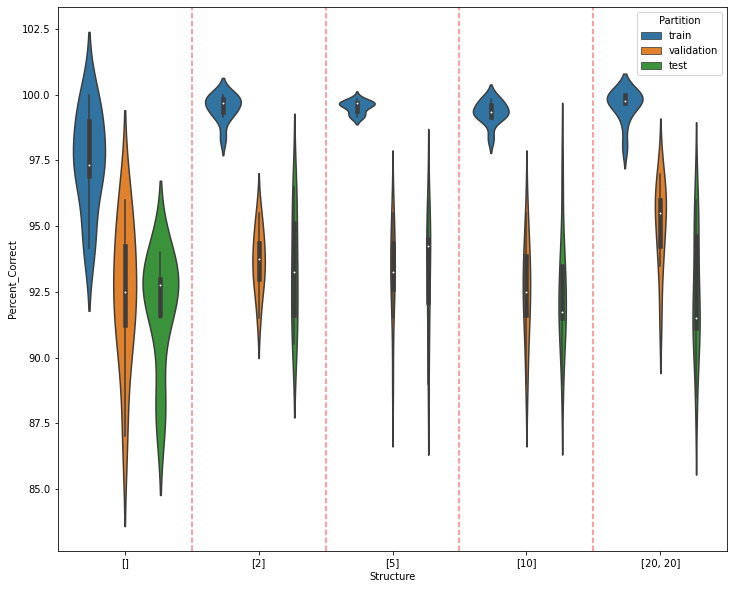

In [16]:
import seaborn as sns

plt.figure(figsize=(12, 10))
sns.violinplot(x='Structure', y='Percent_Correct', hue='Partition', data=resultsdf)
for x in range(len(n_hiddens_list) - 1):
    plt.axvline(x + 0.5, color='r', linestyle='--', alpha=0.5)

RMSEBased on results in violin plots, pick best network structure (according to performance in validation data) and train a network using that structure.  Then apply the trained network using `nnet.use` on the training, validation and testing partitions.  Report the performance of each, and, for classification problems, show the confusion matrices.  See examples below.

In [17]:
nnet = NeuralNetworkClassifierTorch(Xflat.shape[1], [10], len(np.unique(T)),"cpu")
Xtrain, Ttrain, Xval, Tval, Xtest, Ttest = partition(Xflat, T, (0.6, 0.2, 0.2),
                                         shuffle=True, classification=True)
nnet.train(Xtrain, Ttrain, n_epochs, learning_rate, method='adam', Xval=Xval, Tval=Tval, verbose=True)

Epoch 50 LL train 0.9948 val 0.8635
Epoch 100 LL train 0.9982 val 0.8544
Epoch 150 LL train 0.9988 val 0.8468
Epoch 200 LL train 0.9991 val 0.8402
Epoch 250 LL train 0.9993 val 0.8350
Epoch 300 LL train 0.9995 val 0.8308
Epoch 350 LL train 0.9996 val 0.8272
Epoch 400 LL train 0.9996 val 0.8238
Epoch 450 LL train 0.9997 val 0.8208
Epoch 500 LL train 0.9997 val 0.8180


NeuralNetworkClassifierTorch(400, [10], 2, device=cpu)

In [18]:
C_train, P_train = nnet.use(Xtrain)
confusion_matrix(C_train, Ttrain)

Percent Correct is 99.5


,0.0,1.0
0.0,99.0,1.0
1.0,0.0,100.0


In [19]:
C_val, P_val = nnet.use(Xval)
confusion_matrix(C_val, Tval)

Percent Correct is 95.0


,0.0,1.0
0.0,92.0,8.0
1.0,2.0,98.0


In [20]:
C_test, P_test = nnet.use(Xtest)
confusion_matrix(C_test, Ttest)

Percent Correct is 91.5


,0.0,1.0
0.0,86.0,14.0
1.0,3.0,97.0


In [21]:
fractions = (0.6, 0.2, 0.2)
n_conv_list = [ [(5, (3, 3), (1, 1))],
                [(5, (3, 3), (1, 1)), (4, (4, 4), (2, 2))]
              ]
n_fc_list = [[], [5], [10, 10]]  # Notice the first one... []
n_epochs = 200
learning_rate = 0.01

n_partitions = 10
# print(X.shape)
results = []
for nconv in n_conv_list:
    for nfc in n_fc_list:
        results.extend(multiple_runs_convolutional(n_partitions, X, T, fractions, nconv, nfc, n_epochs, learning_rate))
    
resultsdf1 = pd.DataFrame(results, columns=('Structure', 'Partition', 'Percent_Correct'))

Structure [(5, (3, 3), (1, 1))] []: Repetition 1 2 3 4 5 6 7 8 9 10 
Structure [(5, (3, 3), (1, 1))] [5]: Repetition 1 2 3 4 5 6 7 8 9 10 
Structure [(5, (3, 3), (1, 1))] [10, 10]: Repetition 1 2 3 4 5 6 7 8 9 10 
Structure [(5, (3, 3), (1, 1)), (4, (4, 4), (2, 2))] []: Repetition 1 2 3 4 5 6 7 8 9 10 
Structure [(5, (3, 3), (1, 1)), (4, (4, 4), (2, 2))] [5]: Repetition 1 2 3 4 5 6 7 8 9 10 
Structure [(5, (3, 3), (1, 1)), (4, (4, 4), (2, 2))] [10, 10]: Repetition 1 2 3 4 5 6 7 8 9 10 


In [22]:
resultsdf1

,Structure,Partition,Percent_Correct
0,"[(5, (3, 3), (1, 1))] []",train,100.0
1,"[(5, (3, 3), (1, 1))] []",validation,99.5
2,"[(5, (3, 3), (1, 1))] []",test,100.0
3,"[(5, (3, 3), (1, 1))] []",train,100.0
4,"[(5, (3, 3), (1, 1))] []",validation,100.0
...,...,...,...
175,"[(5, (3, 3), (1, 1)), (4, (4, 4), (2, 2))] [10...",validation,100.0
176,"[(5, (3, 3), (1, 1)), (4, (4, 4), (2, 2))] [10...",test,100.0
177,"[(5, (3, 3), (1, 1)), (4, (4, 4), (2, 2))] [10...",train,100.0
178,"[(5, (3, 3), (1, 1)), (4, (4, 4), (2, 2))] [10...",validation,99.5


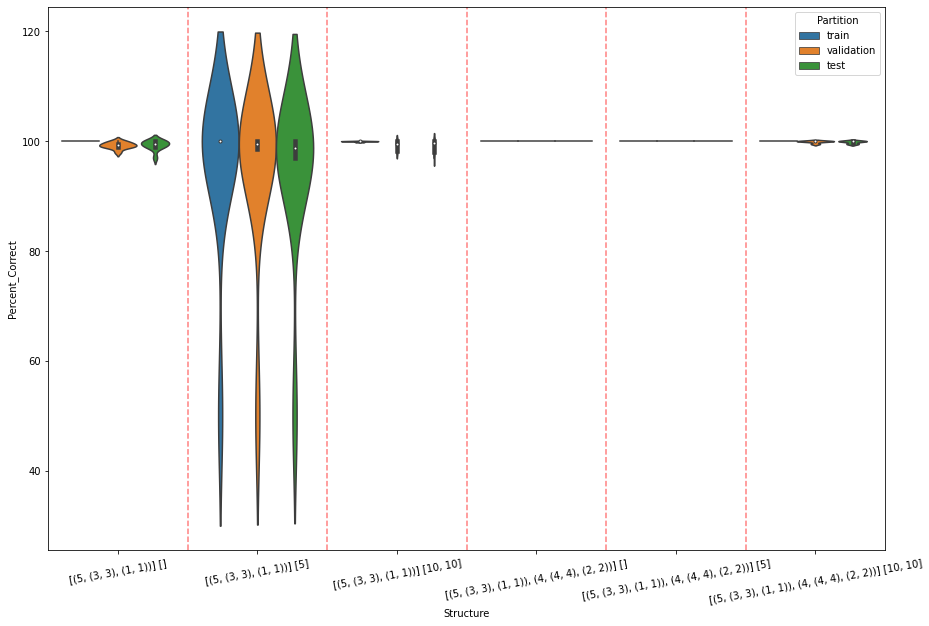

In [23]:
import seaborn as sns

plt.figure(figsize=(15, 10))
sns.violinplot(x='Structure', y='Percent_Correct', hue='Partition', data=resultsdf1)
plt.xticks(rotation=10)

for x in range(len(n_conv_list) * len(n_fc_list) - 1):
    plt.axvline(x + 0.5, color='r', linestyle='--', alpha=0.5)

# Application to Three Data Sets

In the following experiments, you may try a variety of learning_rates, numbers of epochs, and network structures, but in the violin plot use one value for learning_rate, one value for number of epochs, and six values of network structure.

Apply `multiple_runs_regression` for various network structures to the automobile data introduced in Lecture Notes 17.  Load it as follows.

In [26]:

if os.path.isfile('automobile.csv'):
    print('Reading data from \'automobile.csv\'.')
    automobile = pd.read_csv('automobile.csv')
else:
    print('Downloading auto-mpg.data from UCI ML Repository.')
    automobile = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data',
                             header=None, delimiter='\s+', na_values='?', 
                             usecols=range(8))
    automobile.columns = ('mpg', 'cylinders', 'displacement', 'horsepower', 'weight',
                          'acceleration', 'year', 'origin')

    print(f'Number rows in original data file {len(automobile)}.')
    automobile = automobile.dropna(axis=0)
    print(f'Number rows after dropping rows with missing values {len(automobile)}.')
    automobile.to_csv('automobile.csv', index=False)  # so row numbers are not written to file
    
T = automobile['mpg'].values.reshape(-1, 1)
X = automobile.iloc[:, 1:].values
X.shape, T.shape

Reading data from 'automobile.csv'.


((392, 7), (392, 1))

In [27]:
fractions = (0.6, 0.2, 0.2)
n_hiddens_list = [[],[100, 100],[200,200],[500,500]]
n_epochs = 1000
learning_rate = 0.01
results =[]
n_partitions = 10

for nh in n_hiddens_list:
    results.extend(multiple_runs_regression(n_partitions, X, T, fractions, nh, n_epochs, learning_rate))
    
resultsdf_reg = pd.DataFrame(results, columns=('Structure', 'Partition', 'RMSE'))

Structure []: Repetition 1 2 3 4 5 6 7 8 9 10 
Structure [100, 100]: Repetition 1 2 3 4 5 6 7 8 9 10 
Structure [200, 200]: Repetition 1 2 3 4 5 6 7 8 9 10 
Structure [500, 500]: Repetition 1 2 3 4 5 6 7 8 9 10 


In [253]:
resultsdf_reg

,Structure,Partition,RMSE
0,[],train,3.308487
1,[],validation,2.994811
2,[],test,3.694467
3,[],train,3.486619
4,[],validation,2.860407
...,...,...,...
115,"[500, 500]",validation,2.464493
116,"[500, 500]",test,2.949528
117,"[500, 500]",train,1.581401
118,"[500, 500]",validation,3.323549


In [278]:
Confusion_df = resultsdf_reg[resultsdf_reg["Partition"].str.contains("validation")]

Confusion_df.sort_values(by=['RMSE'], ascending=True).head()

,Structure,Partition,RMSE
88,"[200, 200]",validation,2.069168
37,"[100, 100]",validation,2.198810
64,"[200, 200]",validation,2.219026
70,"[200, 200]",validation,2.226953
85,"[200, 200]",validation,2.313113


In [288]:
best = resultsdf_reg[resultsdf_reg["Structure"].str.contains("200")]
best
# best.sort_values(by=['RMSE'], ascending=True)

,Structure,Partition,RMSE
60,"[200, 200]",train,2.278715
61,"[200, 200]",validation,2.930150
62,"[200, 200]",test,2.388302
63,"[200, 200]",train,2.905783
64,"[200, 200]",validation,2.219026
65,"[200, 200]",test,2.453821
66,"[200, 200]",train,1.412493
67,"[200, 200]",validation,2.447460
68,"[200, 200]",test,3.321704
69,"[200, 200]",train,1.823506


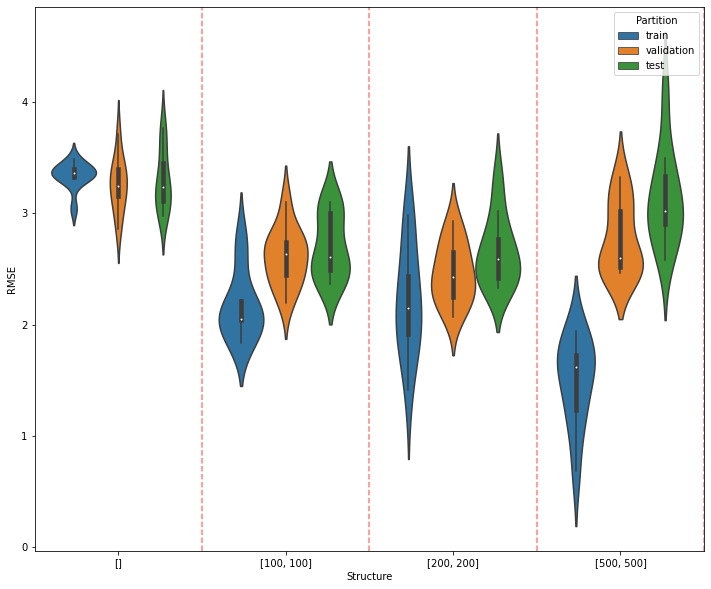

In [276]:
import seaborn as sns
plt.figure(figsize=(12, 10))
sns.violinplot(x='Structure', y='RMSE', hue='Partition', data=resultsdf_reg)
for x in range(len(n_hiddens_list) - 1):
    plt.axvline(x + 0.5, color='r', linestyle='--', alpha=0.5)


Apply `multiple_runs_classification` for various network structures to the following data set from a study in diabetes diagnosis.

In [36]:
if os.path.isfile('diabetes.csv'):
    print('Reading data from \'diabetes.csv\'.')
    diabetes = pd.read_csv('diabetes.csv')
else:
    print('Downloading diabetes_data_upload.csv from UCI ML Repository.')
    diabetes = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00529/diabetes_data_upload.csv')
                        # usecols=range(1,14))
    if False:
        print(f'Number rows in original data file {len(diabetes)}.')
        diabetes = diabetes.dropna(axis=0)
        print(f'Number rows after dropping rows with missing values {len(diabetes)}.')
    converter = dict(Yes=1, No=0, Female=1, Male=0, Positive=1, Negative=0)
    diabetes = diabetes.applymap(lambda x: converter.get(x, x))
    diabetes.to_csv('diabetes.csv', index=False)  # so row numbers are not written to file

X = diabetes.iloc[:, :-1].values
T = diabetes.iloc[:, -1:].values

X.shape, T.shape

Reading data from 'diabetes.csv'.


((520, 16), (520, 1))

In [29]:
len(np.unique(T))

2

In [39]:
fractions = (0.6, 0.2, 0.2)
n_hiddens_list = [[], [2], [5], [10], [20, 20]]  # Notice the first one... []
n_epochs = 500
learning_rate = 0.01

n_partitions = 10

results = []
for nh in n_hiddens_list:
    results.extend(multiple_runs_classification(n_partitions, X, T, fractions, nh, n_epochs, learning_rate))
    
resultsdf = pd.DataFrame(results, columns=('Structure', 'Partition', 'RMSE'))

Structure []: Repetition 1 2 3 4 5 6 7 8 9 10 
Structure [2]: Repetition 1 2 3 4 5 6 7 8 9 10 
Structure [5]: Repetition 1 2 3 4 5 6 7 8 9 10 
Structure [10]: Repetition 1 2 3 4 5 6 7 8 9 10 
Structure [20, 20]: Repetition 1 2 3 4 5 6 7 8 9 10 


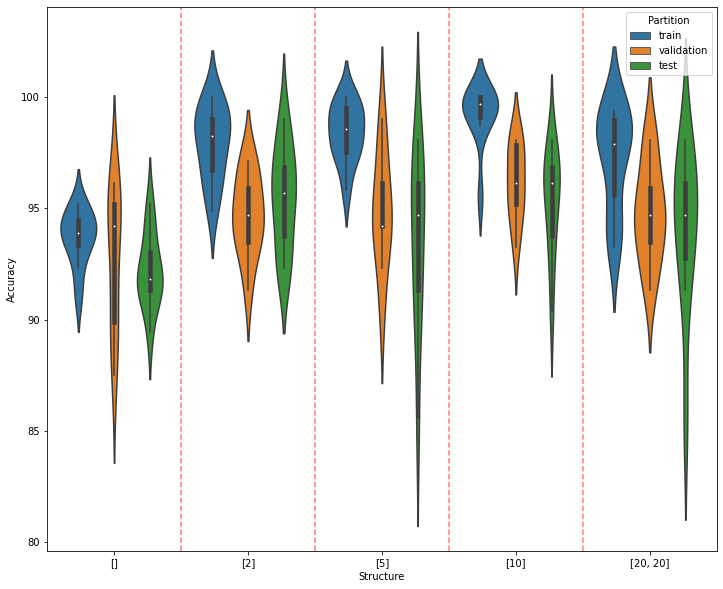

In [239]:
import seaborn as sns

plt.figure(figsize=(12, 10))
sns.violinplot(x='Structure', y='RMSE', hue='Partition', data=resultsdf)
for x in range(len(n_hiddens_list) - 1):
    plt.axvline(x + 0.5, color='r', linestyle='--', alpha=0.5)

In [76]:
Confusion_df_classification = resultsdf[resultsdf["Partition"].str.contains("validation")]

Confusion_df_classification.sort_values(by=['Accuracy'], ascending=False).head()

,Structure,Partition,Accuracy
148,"[20, 20]",validation,99.038462
82,[5],validation,99.038462
112,[10],validation,98.076923
73,[5],validation,98.076923
106,[10],validation,98.076923


In [39]:
nnet = NeuralNetworkClassifierTorch(X.shape[1], [10], len(np.unique(T)),"cpu")
Xtrain, Ttrain, Xval, Tval, Xtest, Ttest = partition(X, T, (0.6, 0.2, 0.2),
                                         shuffle=True, classification=True)
nnet.train(Xtrain, Ttrain, n_epochs, learning_rate, method='adam', Xval=Xval, Tval=Tval, verbose=True)

Epoch 100 LL train 0.9125 val 0.8509
Epoch 200 LL train 0.9680 val 0.8349
Epoch 300 LL train 0.9801 val 0.8273
Epoch 400 LL train 0.9850 val 0.8382
Epoch 500 LL train 0.9881 val 0.8466
Epoch 600 LL train 0.9904 val 0.8424
Epoch 700 LL train 0.9922 val 0.8345
Epoch 800 LL train 0.9938 val 0.8271
Epoch 900 LL train 0.9950 val 0.8213
Epoch 1000 LL train 0.9959 val 0.8178


NeuralNetworkClassifierTorch(16, [10], 2, device=cpu)

In [40]:
C_train, P_train = nnet.use(Xtrain)
confusion_matrix(C_train, Ttrain)

Percent Correct is 96.7948717948718


,0,1
0,95.833333,4.166667
1,2.604167,97.395833


In [41]:
C_train, P_train = nnet.use(Xval)
confusion_matrix(C_train, Tval)

Percent Correct is 95.1923076923077


,0,1
0,97.50,2.50
1,6.25,93.75


In [42]:
C_train, P_train = nnet.use(Xtest)
confusion_matrix(C_train, Ttest)

Percent Correct is 96.15384615384616


,0,1
0,100.00,0.00
1,6.25,93.75


Apply `multiple_runs_convolutional` for various network structures to the following small subset of the MNIST data that contains 500 samples of each digit.

In [258]:
if os.path.isfile('small_mnist.npz'):
    print('Reading data from \'small_mnist.npz\'.')
    small_mnist = np.load('small_mnist.npz')
else:
    import shlex
    import subprocess
    print('Downloading small_mnist.npz from CS545 site.')
    cmd = 'curl "https://www.cs.colostate.edu/~anderson/cs545/notebooks/small_mnist.npz" -o "small_mnist.npz"'
    subprocess.call(shlex.split(cmd))
    small_mnist = np.load('small_mnist.npz')


X = small_mnist['X']
X = X.reshape(-1, 1, 28, 28)
T = small_mnist['T']

X.shape, T.shape

Reading data from 'small_mnist.npz'.


((1000, 1, 28, 28), (1000, 1))

In [95]:
len(np.unique(T))

10

In [67]:
fractions = (0.6, 0.2, 0.2)
n_conv_list = [ [(5, (3, 3), (1, 1))],
                [(5, (3, 3), (1, 1)), (4, (4, 4), (2, 2))]
              ]
n_fc_list = [[], [5], [10, 10]]  # Notice the first one... []
n_epochs = 200
learning_rate = 0.01

n_partitions = 10
# print(X.shape)
results = []
for nconv in n_conv_list:
    for nfc in n_fc_list:
        results.extend(multiple_runs_convolutional(n_partitions, X, T, fractions, nconv, nfc, n_epochs, learning_rate))
    
resultsdf_conv= pd.DataFrame(results, columns=('Structure', 'Partition', 'Accuracy'))

Structure [(5, (3, 3), (1, 1))] []: Repetition 1 2 3 4 5 6 7 8 9 10 
Structure [(5, (3, 3), (1, 1))] [5]: Repetition 1 2 3 4 5 6 7 8 9 10 
Structure [(5, (3, 3), (1, 1))] [10, 10]: Repetition 1 2 3 4 5 6 7 8 9 10 
Structure [(5, (3, 3), (1, 1)), (4, (4, 4), (2, 2))] []: Repetition 1 2 3 4 5 6 7 8 9 10 
Structure [(5, (3, 3), (1, 1)), (4, (4, 4), (2, 2))] [5]: Repetition 1 2 3 4 5 6 7 8 9 10 
Structure [(5, (3, 3), (1, 1)), (4, (4, 4), (2, 2))] [10, 10]: Repetition 1 2 3 4 5 6 7 8 9 10 


In [75]:
resultsdf_conv

,Structure,Partition,Accuracy
0,"[(5, (3, 3), (1, 1))] []",train,94.333333
1,"[(5, (3, 3), (1, 1))] []",validation,87.000000
2,"[(5, (3, 3), (1, 1))] []",test,85.000000
3,"[(5, (3, 3), (1, 1))] []",train,96.500000
4,"[(5, (3, 3), (1, 1))] []",validation,86.000000
...,...,...,...
175,"[(5, (3, 3), (1, 1)), (4, (4, 4), (2, 2))] [10...",validation,84.000000
176,"[(5, (3, 3), (1, 1)), (4, (4, 4), (2, 2))] [10...",test,78.500000
177,"[(5, (3, 3), (1, 1)), (4, (4, 4), (2, 2))] [10...",train,97.666667
178,"[(5, (3, 3), (1, 1)), (4, (4, 4), (2, 2))] [10...",validation,84.500000


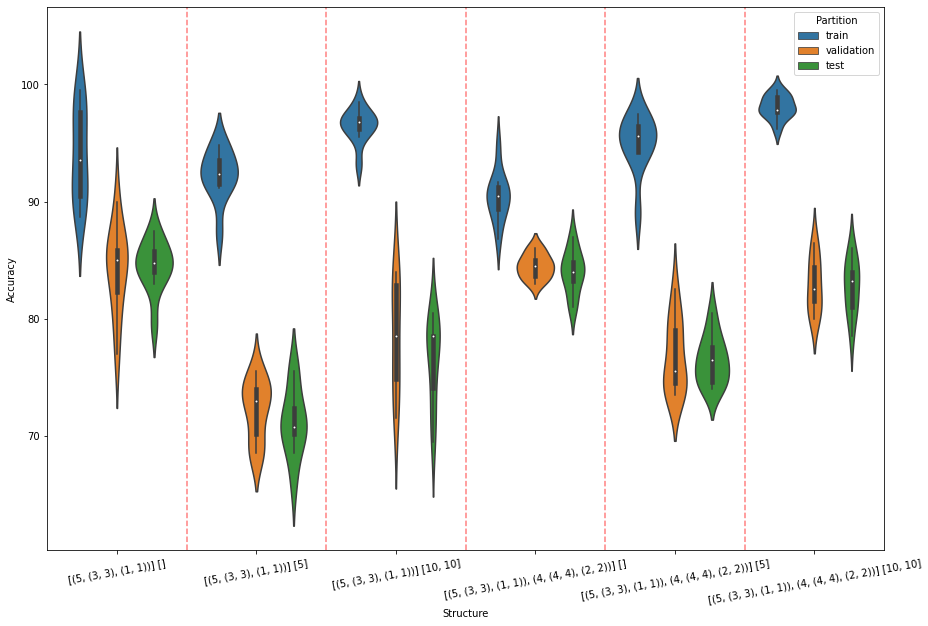

In [68]:
import seaborn as sns

plt.figure(figsize=(15, 10))
sns.violinplot(x='Structure', y='Accuracy', hue='Partition', data=resultsdf_conv)
plt.xticks(rotation=10)

for x in range(len(n_conv_list) * len(n_fc_list) - 1):
    plt.axvline(x + 0.5, color='r', linestyle='--', alpha=0.5)

In [72]:
Confusion_df_conv = resultsdf_conv[resultsdf_conv["Partition"].str.contains("validation")]

Confusion_df_conv.sort_values(by=['Accuracy'], ascending=False).head()

,Structure,Partition,Accuracy
22,"[(5, (3, 3), (1, 1))] []",validation,90.0
1,"[(5, (3, 3), (1, 1))] []",validation,87.0
172,"[(5, (3, 3), (1, 1)), (4, (4, 4), (2, 2))] [10...",validation,86.5
163,"[(5, (3, 3), (1, 1)), (4, (4, 4), (2, 2))] [10...",validation,86.0
115,"[(5, (3, 3), (1, 1)), (4, (4, 4), (2, 2))] []",validation,86.0


In [96]:
nnet = NeuralNetworkClassifierConvolutionalTorch(X.shape[1:], ([(5, (3, 3), (1, 1))]), ([]), len(np.unique(T)))
Xtrain, Ttrain, Xval, Tval, Xtest, Ttest = partition(X, T, (0.6, 0.2, 0.2),
                                         shuffle=True, classification=True)
nnet.train(Xtrain, Ttrain, 200, learning_rate, method='adam', Xval=Xval, Tval=Tval, verbose=True)

Epoch 20 LL train 0.9579 val 0.5680
Epoch 40 LL train 0.9971 val 0.5313
Epoch 60 LL train 0.9990 val 0.5191
Epoch 80 LL train 0.9993 val 0.5137
Epoch 100 LL train 0.9994 val 0.5129
Epoch 120 LL train 0.9995 val 0.5122
Epoch 140 LL train 0.9996 val 0.5105
Epoch 160 LL train 0.9996 val 0.5088
Epoch 180 LL train 0.9997 val 0.5071
Epoch 200 LL train 0.9997 val 0.5055


NeuralNetworkClassifierConvolutionalTorch(n_inputs=784, n_conv_list=[(5, (3, 3), (1, 1))], n_fc_list=[], n_outputs=10, device=cpu)

In [97]:
C_train, P_train = nnet.use(Xtrain)
confusion_matrix(C_train, Ttrain)

Percent Correct is 98.5


,0,1,2,3,4,5,6,7,8,9
0,98.333333,0.000000,0.000000,0.000000,0.000000,1.666667,0.000000,0.0,0.000000,0.000000
1,0.000000,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
2,0.000000,0.000000,98.333333,1.666667,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
3,0.000000,0.000000,0.000000,100.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,100.000000,0.000000,0.000000,0.0,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,1.666667,96.666667,0.000000,0.0,1.666667,0.000000
6,0.000000,1.666667,0.000000,0.000000,0.000000,0.000000,98.333333,0.0,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100.0,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,100.000000,0.000000
9,1.666667,0.000000,0.000000,0.000000,1.666667,0.000000,0.000000,0.0,3.333333,93.333333


In [98]:
C_val, P_val = nnet.use(Xval)
confusion_matrix(C_val, Tval)

Percent Correct is 87.5


,0,1,2,3,4,5,6,7,8,9
0,95.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0
1,0.0,95.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5.0,5.0,75.0,5.0,5.0,0.0,0.0,0.0,5.0,0.0
3,0.0,0.0,0.0,95.0,0.0,0.0,0.0,0.0,0.0,5.0
4,0.0,0.0,5.0,0.0,90.0,0.0,0.0,0.0,0.0,5.0
5,0.0,0.0,0.0,0.0,0.0,55.0,10.0,5.0,15.0,15.0
6,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0
7,0.0,5.0,0.0,0.0,0.0,0.0,0.0,95.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,5.0,5.0,0.0,90.0,0.0
9,0.0,0.0,0.0,5.0,0.0,0.0,0.0,10.0,0.0,85.0


In [99]:
C_test, P_test = nnet.use(Xtest)
confusion_matrix(C_test, Ttest)

Percent Correct is 86.0


,0,1,2,3,4,5,6,7,8,9
0,95.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0
1,0.0,95.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
2,0.0,5.0,70.0,10.0,5.0,0.0,0.0,0.0,5.0,5.0
3,0.0,0.0,0.0,85.0,0.0,5.0,0.0,5.0,0.0,5.0
4,0.0,0.0,0.0,0.0,95.0,0.0,0.0,0.0,0.0,5.0
5,0.0,0.0,0.0,10.0,5.0,80.0,0.0,0.0,5.0,0.0
6,0.0,0.0,5.0,0.0,5.0,0.0,90.0,0.0,0.0,0.0
7,0.0,5.0,0.0,0.0,5.0,5.0,0.0,80.0,0.0,5.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,95.0,0.0
9,0.0,0.0,0.0,5.0,0.0,0.0,0.0,20.0,0.0,75.0


For each of the three applications, make violin plots.  For classification problems, also show the confusion matrices.  Describe the results you see with at least 10 sentences for each application, for a total of at least 30 sentences.

# Discussion

## Regression:
1. The validation RMSE of [200,200] configuration had the least value the correponding Test RSME was also low in this case.
2. While training the RMSE value of test data for the corresponding hidden_list was also lower than the others.
3. This behaviour of the neural network shows that the network is trained properly and generalies well. 
4. Even though the train RMSE of the configuration [500,500] is way too low compared to that of any other nnet when can see that the Validation and test RMSE is very high. 
5. This proves that the Configuration([500,500]) does not converge well and can be adjusted to perform even better. 
6. The linear configuration does not behave well and also converges in a very short span the over all range is between 2.5 and 3.5.
7. When you compare this to the best configuration we can see that the range is between 0.5 and 3.5 during training which shows that the neural network ran was performing very well.
8. During validation [200,200] configuration had a range between 1.9 and 3.5 which means the neural net has generalised really good. 
9. the [100,100] configuration shows close resembeles to the best configuration which is [200,200] which may give better results with higher learning rate and epochs. 
10. I think over from the above graph we can see a new view in which the training happens where each partition contributs and also gives us a more indepth analysis  of the training, validation and testing. 

## Classification: 
1. The neural net was trained for various hiddenlist configuration with same epochs and learning rate. 
2. We can observe that the best validation accuracy is for the configuration[10,10] with the highest validation accuracy of 99 percent. 
3. the volin plot shows that the mean of the configuration is at 95 % and the least is at 90 % accuracy fo validation.
4. The test accuracy is very close to the validation accuracy for the configuration which shows it has a good generalisation. 
5. Even thou the test start with 80 % accuracy th mean mean of the test accuracy is close to the validation accuracy of the neural net configuration. 
6. We can also see that the mean accuracy of the linear model is very low compared to the other configurations.
7. this shows that the linear configuration does not work well with this problem. 
8. Even thou the [20,20] configuration has higher accuracy rate for validation we can see that the [10] configuration has higher mean compared to the [20,20] configuration.
9. In this cause i went with the [10] conguration has the best configuration since it has higher mean compared to the [20,20]. 

## Convolution:
1. The training accuracy are way  higher than the validation accuracy in case of convolution neural net which proves the classic overfitting in the netwoek./ 
2. The highest accuracy was for the configuration with convolution configuration [(5, (3, 3), (1, 1))] and fc of []. 
3. The kernel size of 3 and stride of 1 along with 5 filters made the network work better. 
4. COnverting the inputs with torch tensor is an addition and very important part of this convolution neural network. 
5. the weights and the layers are also converted to torch tensors. 
6. The accuracy of these networks are lesser compared to the once we saw in the last Assignment where we used the same MNist dataset. This can be overcome by better filters and kernel size. 
7. the highest validation accuracy for th e best configuration was 90% and it hasd a mean closer to 85% which means the generalization is good. 
8. The Test accuracy was same as validation accuracy which can be concluded that model has been trained and generalized properly. 
9. The same convolution configuration when used with fc of [5] the behaviour is very bad it overfits very badly. 
10. With these observation we can see that both the convolution and fc layers are very important for the nnet to generalise. 


The key takeaway is that we have learnt a lot of the mathematics behind a convolution layer. I used to work with keras a lot but working with torch gave me indepth knowledge of now the output of each layer is defined and so. The Assignment was very helpful to understand some key concepts. 

# Grading

Download [A5grader.tar](https://www.cs.colostate.edu/~anderson/cs545/notebooks/A5grader.tar), extract `A5grader.py` before running the following cell.

In [32]:
%run -i A5grader.py


======================= Code Execution =======================

Extracting python code from notebook named 'Balasubramaniam-A5.ipynb' and storing in notebookcode.py
Removing all statements that are not function or class defs or import statements.

## Testing constructor ####################################################################

    nnet = NeuralNetworkClassifierConvolutionalTorch([1, 10, 10], 
                                                     [(2, (3, 3), (1, 1)), (3, (5, 5), (2, 2))],
                                                     [30, 20], 2)

    # Is isinstance(nnet, NeuralNetworkClassifierTorch)   True?


--- 10/10 points. NeuralNetworkClassifierConvolutionalTorch is correctly of type NeuralNetworkClassifierTorch

--- 10/10 points. nnet correctly has 5 pytorch layers.

## Testing train ####################################################################

    np.random.seed(42)
    X = np.random.uniform(0, 1, size=(100, 2))
    T = (np.abs(X[:, 0:1] - X[:, 1:2]

# Extra Credit

Try to train on a GPU for at least one of the datasets by calling one of the `multiple_runs_...` functions.  A simple guide to changes you will need in your code is available at [this site](https://towardsdatascience.com/pytorch-switching-to-the-gpu-a7c0b21e8a99).  You may run on one of the CS department's workstations that have GPUs.

Discuss the execution time on just the CPU and on a GPU.  

In [150]:
torch.cuda.is_available()

True

In [243]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

device

device(type='cuda')

In [259]:
def multiple_runs_convolutional_gpu(n_partitions, X, T, fractions, nconv, nfc, n_epochs, learning_rate,device):
 
    print(f'Structure {str(nconv)+ " " + str(nfc)}: Repetition', end=' ')
    results = []


    for rep in range(n_partitions):

        print(f'{rep + 1}', end=' ')

        Xtrain, Ttrain, Xval, Tval, Xtest, Ttest = partition(X, T, fractions,
                                                             shuffle=True, classification=True)

        Xtrain=torch.from_numpy(Xtrain.astype(np.float32)).to(device)
        Ttrain=torch.from_numpy(Ttrain.astype(np.float32)).to(device)
        Xval=torch.from_numpy(Xval.astype(np.float32)).to(device)
        Tval=torch.from_numpy(Tval.astype(np.float32)).to(device)
        Xtest=torch.from_numpy(Xtest.astype(np.float32)).to(device)
        Ttest=torch.from_numpy(Ttest.astype(np.float32)).to(device)
        
       
        n_outputs = len(np.unique(T).astype(int))
#         print(n_outputs)
        nnet = NeuralNetworkClassifierConvolutionalTorch(X.shape[1:], nconv, nfc, n_outputs).to(device)
        nnet.device = device
    

        nnet.train(Xtrain, Ttrain, n_epochs, learning_rate, method='adam', Xval=Xval, Tval=Tval, verbose=False)
        
        train_percent=percent_correct(nnet.use(Xtrain)[0], Ttrain)
        val_percent = percent_correct(nnet.use(Xval)[0], Tval)
        test_percent = percent_correct(nnet.use(Xtest)[0], Ttest)
#         print(nnet.use(Xtrain), Ttrain)
        structure = str(nconv)+ " " + str(nfc)
        results.extend([[structure, 'train', train_percent],
                        [structure, 'validation', val_percent],
                        [structure, 'test', test_percent]])

#         print(results)
    print()
    return results

In [261]:
fractions = (0.6, 0.2, 0.2)
n_conv_list = [ [(5, (3, 3), (1, 1))],
                [(5, (3, 3), (1, 1)), (4, (4, 4), (2, 2))]
              ]
n_fc_list = [[], [5], [10, 10]]  # Notice the first one... []
n_epochs = 200
learning_rate = 0.01


n_partitions = 10
# print(X.shape)
results = []
for nconv in n_conv_list:
    for nfc in n_fc_list:
        results.extend(multiple_runs_convolutional_gpu(n_partitions, X, T, fractions, nconv, nfc, n_epochs, learning_rate,device=device))
    
resultsdf1 = pd.DataFrame(results, columns=('Structure', 'Partition', 'Accuracy'))

Structure [(5, (3, 3), (1, 1))] []: Repetition 1 2 3 4 5 6 7 8 9 10 
Structure [(5, (3, 3), (1, 1))] [5]: Repetition 1 2 3 4 5 6 7 8 9 10 
Structure [(5, (3, 3), (1, 1))] [10, 10]: Repetition 1 2 3 4 5 6 7 8 9 10 
Structure [(5, (3, 3), (1, 1)), (4, (4, 4), (2, 2))] []: Repetition 1 2 3 4 5 6 7 8 9 10 
Structure [(5, (3, 3), (1, 1)), (4, (4, 4), (2, 2))] [5]: Repetition 1 2 3 4 5 6 7 8 9 10 
Structure [(5, (3, 3), (1, 1)), (4, (4, 4), (2, 2))] [10, 10]: Repetition 1 2 3 4 5 6 7 8 9 10 


In [264]:
resultsdf1

,Structure,Partition,Accuracy
0,"[(5, (3, 3), (1, 1))] []",train,83.833333
1,"[(5, (3, 3), (1, 1))] []",validation,72.000000
2,"[(5, (3, 3), (1, 1))] []",test,73.500000
3,"[(5, (3, 3), (1, 1))] []",train,92.333333
4,"[(5, (3, 3), (1, 1))] []",validation,77.500000
...,...,...,...
175,"[(5, (3, 3), (1, 1)), (4, (4, 4), (2, 2))] [10...",validation,85.000000
176,"[(5, (3, 3), (1, 1)), (4, (4, 4), (2, 2))] [10...",test,78.500000
177,"[(5, (3, 3), (1, 1)), (4, (4, 4), (2, 2))] [10...",train,99.833333
178,"[(5, (3, 3), (1, 1)), (4, (4, 4), (2, 2))] [10...",validation,83.500000


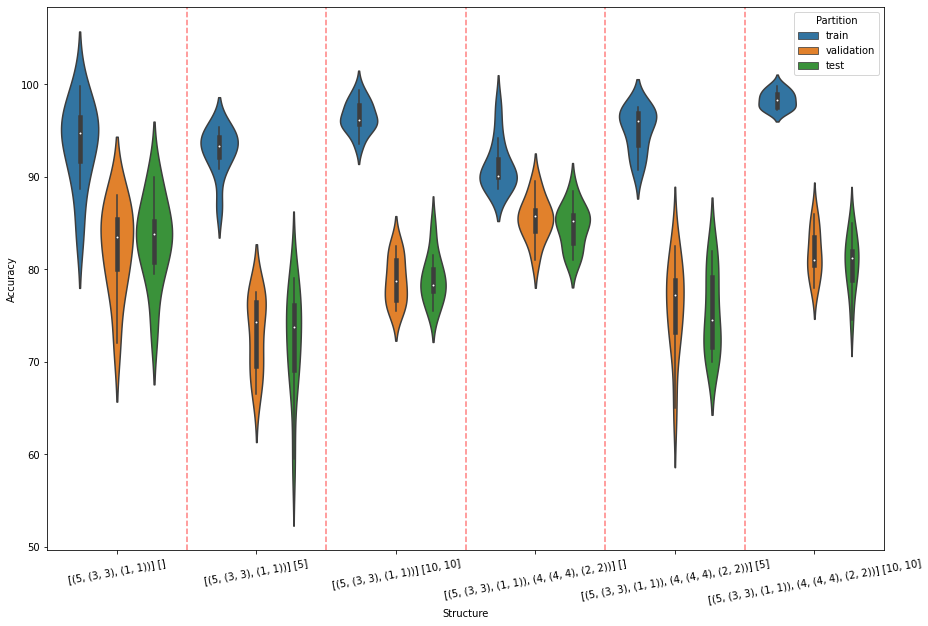

In [265]:
import seaborn as sns

plt.figure(figsize=(15, 10))
sns.violinplot(x='Structure', y='Accuracy', hue='Partition', data=resultsdf1)
plt.xticks(rotation=10)

for x in range(len(n_conv_list) * len(n_fc_list) - 1):
    plt.axvline(x + 0.5, color='r', linestyle='--', alpha=0.5)

# Extra credit discussion

1. We can see that the same configuration was followed for running on a gpu. 
2. Running on a cpu took around 4.55 seconds whereas running on a Gpu took only 29 seconds. 
3. The conversion of the numpy array to tensor and adding it to the gpu based a key role as cuda cores can compute way faster than cpu. 
4. the tricky part was to convert all the values correctly to tensors and add it to the cpu 
5. and also correctly converting them back to cpu for various operations. 
6. The accuracy of running on gpu is little higher than the cpu which proves that the tensor operation has higher mathematical precision. 